# work with model configs and training

**TODO: put this in tutorials, use some for unit testing**

**this core functions on this page are now implemented in [sklearn_classifier.py](sklearn_classifier.py)**

**The are 3 sample class definitions in this folder.  The boosters were written by myself, the LogisticRegression was auto-generated in [get_model_configs("my_favorite_sklearn_class")]() below.**

In [99]:
import json
import os
from importlib import import_module
from inspect import getfullargspec, FullArgSpec
from cloudpickle import dump, load
import itertools

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.testing import all_estimators
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics

from typing import Union, List, Any, Optional
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact

In [100]:
skversion = sklearn.__version__

### generate some data

In [101]:
N_CLASSES = 3
N_FEATURES = 20
N_SAMPLES = 10_000

In [102]:
X, y = make_classification(
    n_samples=N_SAMPLES, 
    n_features=N_FEATURES, 
    n_informative=3, 
    n_redundant=2, 
    n_repeated=0, 
    n_classes=N_CLASSES, 
    n_clusters_per_class=2, 
    weights=None, 
    flip_y=0.01, 
    class_sep=1.0, 
    hypercube=True, 
    shift=0.0, 
    scale=1.0, 
    shuffle=True, 
    random_state=1)

since there is a chance that a sample test set may not contain all classes, we binarize/hot-encode the labels before performing a train-test split:

In [103]:
yb = label_binarize(y, classes=list(range(N_CLASSES)))

In [104]:
y

array([2, 1, 1, ..., 2, 1, 0])

In [105]:
yb

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

In [106]:
# hide a copy of hot_encoded labels yb inside X and split
xtrain, xtest, ytrain, ytest = train_test_split(np.concatenate([X, yb], axis=1), y)

In [107]:
# extract the hot_encoded labels
ytrainb = xtrain[:, -yb.shape[1]:].copy()
xtrain = xtrain[:, :-yb.shape[1]].copy()

In [108]:
assert xtrain.shape[1] == N_FEATURES
assert ytrainb.shape[1] == N_CLASSES

In [109]:
# extract the hot_encoded labels
ytestb = xtest[:, -yb.shape[1]:].copy()
xtest = xtest[:, :-yb.shape[1]].copy()

### model configs - from json

from saved json library of models, models can be<br>
- generic: as defined with sklearn defaults<br>
- from data scientist shared libraries<br>
- good starting point from a previuos hyperparameter auto-tune<br>

See **[generate sklearn model configs and save as json](#generate%20sklearn%20model%20configs.ipynb)**.

In [110]:
# original model config 
from_json       = json.load(open('LogisticRegression.json', 'r'))

# copy for dev and test
config_cp    = from_json.copy()
class_params = config_cp["CLASS"]
fit_params   = config_cp["FIT"]
meta_params  = config_cp["META"]

In [111]:
config_cp

{'CLASS': {'penalty': 'l2',
  'dual': False,
  'tol': 0.0001,
  'C': 1.0,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'class_weight': None,
  'random_state': None,
  'solver': 'warn',
  'max_iter': 100,
  'multi_class': 'warn',
  'verbose': 0,
  'warm_start': False,
  'n_jobs': None,
  'l1_ratio': None},
 'FIT': {'X': None, 'y': None, 'sample_weight': None},
 'META': {'sklearn_version': '0.21.3',
  'classifier': 'sklearn.linear_model.logistic.LogisticRegression'}}

### from api
Or you may have a pre-selected model type or list of models and wish to retrieve specific model configs for submission to a training routine: 

In [112]:
def get_model_configs(
    my_models: Union[str, List[str]],
    class_key = "CLASS",
    fit_key = "FIT",
    meta_key = "META",
) -> Union[dict, List[dict]]:
    """build sklearn model configuration parameters
    
    Take (full) class name of an scikit-learn model 
    and retrieve its `class` and `fit` parameters and
    their default values.
    
    Also returns some useful metadata values for the class
    """
    # get a list of all sklearn estimators
    estimators = all_estimators()
    def _get_estimator(pkg_class):
        """find a specific class in a list of sklearn estimators"""
        my_class = pkg_class.split('.')[-1]
        return list(filter(lambda x: x[0] == my_class, estimators))[0]

    # find estimators corresponding to my_models list
    my_estimators = []
    my_models = [my_models] if isinstance(my_models, str) else my_models
    for model in my_models:
        estimator_name, estimator_class = _get_estimator(model)
        my_estimators.append((estimator_name, estimator_class))

    # get class and fit specs
    estimator_specs = []
    for an_estimator in my_estimators:
        estimator_specs.append((an_estimator[0], # model only name
                                getfullargspec(an_estimator[1]), # class params
                                getfullargspec(an_estimator[1].fit), # fit params
                                an_estimator[1]) # package.module.model
                              )

    model_configs = []

    for estimator in estimator_specs:
        model_json = {class_key: {}, fit_key: {}}
        fit_params = {}

        for i, key in enumerate(model_json.keys()):
            f = estimator[i+1]
            args_paired = []
            defs_paired = []

            # reverse the args since there are fewer defaults than args
            args = f.args
            args.reverse()
            n_args = len(args)

            defs = f.defaults
            if defs is None:
                defs = [defs]
            defs = list(defs)
            defs.reverse()
            n_defs = len(defs)

            n_smallest = min(n_args, n_defs)
            n_largest = max(n_args, n_defs)

            # build 2 lists that can be concatenated
            for ix in range(n_smallest):
                if args[ix] is not "self":
                    args_paired.append(args[ix])
                    defs_paired.append(defs[ix])

            for ix in range(n_smallest, n_largest):
                if ix is not 0 and args[ix] is not "self":
                    args_paired.append(args[ix])
                    defs_paired.append(None)
               # concatenate lists into appropriate structure
            model_json[key] = dict(zip(reversed(args_paired), reversed(defs_paired)))

        model_json[meta_key] = {}
        model_json[meta_key]['sklearn_version'] = skversion
        model_json[meta_key]['class'] = '.'.join([estimator[3].__module__, estimator[0]])
        model_configs.append(model_json)
    if len(model_configs) == 1:
        return model_configs[0]
    else:
        return model_configs

In [113]:
# get a string (or DataItem)
get_model_configs("sklearn.svm.SVC")

{'CLASS': {'C': 1.0,
  'kernel': 'rbf',
  'degree': 3,
  'gamma': 'auto_deprecated',
  'coef0': 0.0,
  'shrinking': True,
  'probability': False,
  'tol': 0.001,
  'cache_size': 200,
  'class_weight': None,
  'verbose': False,
  'max_iter': -1,
  'decision_function_shape': 'ovr',
  'random_state': None},
 'FIT': {'X': None, 'y': None, 'sample_weight': None},
 'META': {'sklearn_version': '0.21.3', 'class': 'sklearn.svm.classes.SVC'}}

In [114]:
# get a list
get_model_configs(my_models = ["sklearn.linear_model.LogisticRegression", 
                               "sklearn.neural_networks.MLPClassifier"])

[{'CLASS': {'penalty': 'l2',
   'dual': False,
   'tol': 0.0001,
   'C': 1.0,
   'fit_intercept': True,
   'intercept_scaling': 1,
   'class_weight': None,
   'random_state': None,
   'solver': 'warn',
   'max_iter': 100,
   'multi_class': 'warn',
   'verbose': 0,
   'warm_start': False,
   'n_jobs': None,
   'l1_ratio': None},
  'FIT': {'X': None, 'y': None, 'sample_weight': None},
  'META': {'sklearn_version': '0.21.3',
   'class': 'sklearn.linear_model.logistic.LogisticRegression'}},
 {'CLASS': {'hidden_layer_sizes': (100,),
   'activation': 'relu',
   'solver': 'adam',
   'alpha': 0.0001,
   'batch_size': 'auto',
   'learning_rate': 'constant',
   'learning_rate_init': 0.001,
   'power_t': 0.5,
   'max_iter': 200,
   'shuffle': True,
   'random_state': None,
   'tol': 0.0001,
   'verbose': False,
   'warm_start': False,
   'momentum': 0.9,
   'nesterovs_momentum': True,
   'early_stopping': False,
   'validation_fraction': 0.1,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e

## how to update a model config

Take a look at the Scikit-Learn documentation for the models you are considering, making sure that the documentation version is the same as the version installed on your system (including nodes).  This is because the `model_config` that is built through the api is identical to the documented version.

So for example, here we retrieve a **[SVC model](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)** config, and note it has a `random_state` parameter in its class `__init__` function. 
* **`random_state`** To enable reproducible runs, this parameter is set to some fixed constant.  
* **`probability`** Per class calibrated probability estimates using Scikit-Learn's default `predict_proba` only when this set to `True`, by default it is `False`

This would be done as follows:

In [135]:
svc_model = get_model_configs("sklearn.svm.SVC")
class_params = svc_model["CLASS"]
class_params

{'C': 1.0,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'coef0': 0.0,
 'shrinking': True,
 'probability': False,
 'tol': 0.001,
 'cache_size': 200,
 'class_weight': None,
 'verbose': False,
 'max_iter': -1,
 'decision_function_shape': 'ovr',
 'random_state': None}

In [136]:
class_updates = {
    'random_state'   : 1,
    'probability' : True
}

class_params.update(class_updates)
class_params

{'C': 1.0,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'coef0': 0.0,
 'shrinking': True,
 'probability': True,
 'tol': 0.001,
 'cache_size': 200,
 'class_weight': None,
 'verbose': False,
 'max_iter': -1,
 'decision_function_shape': 'ovr',
 'random_state': 1}

Similarly we modify the fit function by defining what the `X` and `y` inputs are.  In a later example we look at adding more complex fit parameters like callbacks so training histories and checkpoints can be saved.

In [137]:
fit_params = svc_model["FIT"]
fit_params

{'X': None, 'y': None, 'sample_weight': None}

In [138]:
fit_updates = {
    'X': xtrain,
    'y': ytrain
}

fit_params.update(fit_updates)
# fit_params

#### what metadata does the model config contain:

In [139]:
meta_params = svc_model["META"]
meta_params

{'sklearn_version': '0.21.3', 'class': 'sklearn.svm.classes.SVC'}

#### define an update function instead:

In [140]:
def update_model_config(
    config: dict,
    new_class: dict,
    new_fit: dict,
    class_key: str = "CLASS",
    fit_key: str = "FIT"
):
    """Update model config json -- simple version
    
    TODO:  currently a model config contains 2 keys, but this will likely
    expand to include other functions beyond class and fit. So need to expand 
    this to a list of Tuple(str, dict), where `str` corresponds to a key
    in the model config and `dict` contains the params and their new values.
    
    :param config:      original model definition containing 2 keys, CLASS and FIT
    :param new_class:   new class key-values
    :param new_fit:     new fit key-values
    """
    config[class_key].update(new_class)
    config[fit_key].update(new_fit)
    
    return config

In [141]:
new_config = update_model_config(get_model_configs("sklearn.svm.SVC"), class_updates, fit_updates)

In [142]:
new_config

{'CLASS': {'C': 1.0,
  'kernel': 'rbf',
  'degree': 3,
  'gamma': 'auto_deprecated',
  'coef0': 0.0,
  'shrinking': True,
  'probability': True,
  'tol': 0.001,
  'cache_size': 200,
  'class_weight': None,
  'verbose': False,
  'max_iter': -1,
  'decision_function_shape': 'ovr',
  'random_state': 1},
 'FIT': {'X': array([[-0.56435529, -1.39231446, -0.07028216, ..., -0.25740209,
           0.65557798, -0.07062508],
         [ 0.2569468 ,  0.63678742,  0.71921316, ..., -0.80852941,
          -1.84950425,  1.94417399],
         [ 0.55224103,  1.71121254, -0.59955394, ..., -0.7049404 ,
          -0.27544553,  0.12399188],
         ...,
         [-0.68455639, -2.4022995 , -0.75140307, ..., -2.17360859,
          -1.56854182, -0.77668474],
         [ 0.05720765,  1.46950158, -0.29348238, ..., -0.19530871,
           1.3762701 , -0.06452349],
         [ 1.98137244, -0.01355467, -0.48424314, ...,  0.48177525,
           0.50924417,  0.11233518]]),
  'y': array([1, 0, 2, ..., 2, 2, 1]),
  'samp

In [143]:
def _create_class(pkg_class: str):
    """Create a class from a package.module.class string

    :param pkg_class:  full class location,
                       e.g. "sklearn.model_selection.GroupKFold"
    """
    splits = pkg_class.split(".")
    clfclass = splits[-1]
    pkg_module = splits[:-1]
    class_ = getattr(import_module(".".join(pkg_module)), clfclass)
    return class_

In [144]:
ClassifierClass = _create_class(meta_params["class"])

In [145]:
clf = ClassifierClass(**class_params)
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=1, shrinking=True,
    tol=0.001, verbose=False)

In [146]:
clf.fit(**fit_params)

/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=1, shrinking=True,
    tol=0.001, verbose=False)

In [147]:
y_probs = clf.predict_proba(xtest)
print(y_probs.shape)
assert y_probs.shape[1] == N_CLASSES

(2500, 3)


In [148]:
def _gcf_clear(plt):
    """Utility to clear matplotlib figure

    Run this inside every plot method before calling any matplotlib
    methods

    :param plot:    matloblib figure object
    """
    plt.cla()
    plt.clf()
    plt.close()

In [149]:
def plot_roc(
    y_labels,
    y_probs,
    key="roc",
    plots_dir: str = "plots",
    fmt="png",
    x_label: str = "false positive rate",
    y_label: str =  "true positive rate",
    title: str = "roc curve",
    legend_loc: str = "best"
):
    """plot roc curves
    
    TODO:  add averaging method (as string) that was used to create probs, 
    display in legend
    
    :param y_labels:     ground truth labels, hot encoded for multiclass  
    :param y_probs:      model prediction probabilities
    :param key:          ("roc") key of plot in artifact store
    :param plots_dir:    ("plots") destination folder relative path to artifact path
    :param fmt:          ("png") plot format
    :param x_label:      ("false positive rate") x-axis labels
    :param y_label:      ("true positive rate") y-axis labels
    :param title:        ("roc curve") title of plot
    :param legend_loc:   ("best") location of plot legend
    """
    assert y_probs.shape == y_labels.shape
    
    # clear matplotlib current figure
    _gcf_clear(plt)
    
    # data accummulators by class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # draw 45 degree line
    plt.plot([0, 1], [0, 1], "k--")
    
    # labelling
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc=legend_loc)
    
    # single ROC or mutliple
    for i in range(y_labels.shape[1]):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_labels[:, i], y_probs[:, i], pos_label=1)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"class {i}")

No handles with labels found to put in legend.


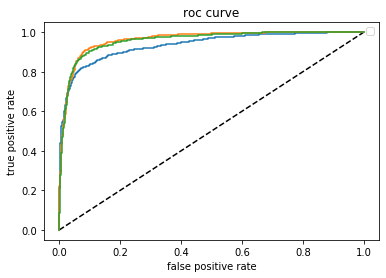

In [150]:
plot_roc(ytestb, y_probs)

In [162]:
def plot_confusion_matrix(labels, predictions, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         font = {'family' : 'serif',
                                 'color'  : 'darkgreen',
                                 'weight' : 'normal',
                                 'size'   : 14,
                                }):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(labels, predictions)
    plt.gcf().set_size_inches(30, 10)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict=font)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontdict=font)

    #plt.tight_layout()
    plt.ylabel('True label', fontdict=font)
    plt.xlabel('Predicted label', fontdict=font)

In [163]:
# import matplotlib
# matplotlib.rc('figure', figsize=(20, 20))

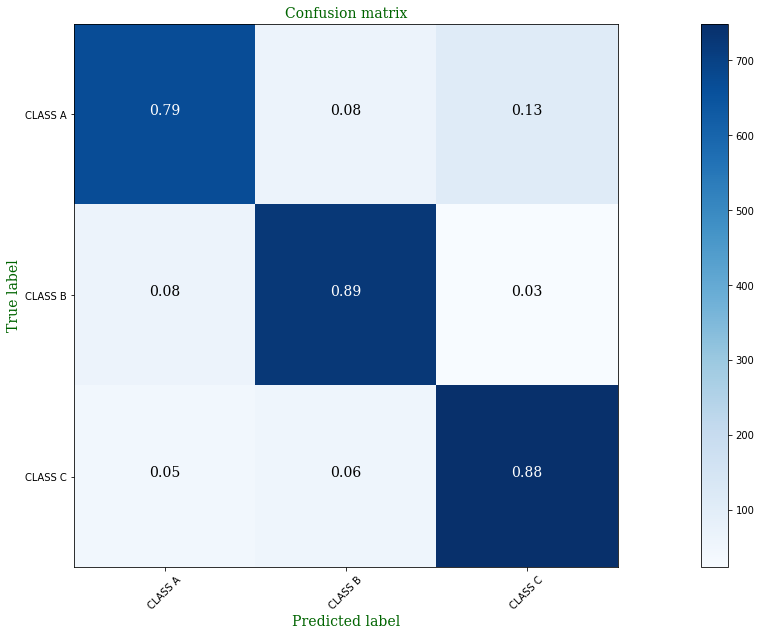

In [164]:
plot_confusion_matrix(ytest, clf.predict(xtest), ["CLASS A", "CLASS B", "CLASS C"])